In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import Input,Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3,VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,TensorBoard

In [3]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
print ('Number of devices: %d' % strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [4]:
# Veri seti klasörünün yolu (Data klasörünüzün yolu)
data_dir = Path('Dataset/Train')
filepaths = list(data_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images, train_size=0.75, shuffle=True, random_state=42)

In [5]:
batch_size = 4
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
) # %70 eğitim datası içinden ön eğitim kontrölü içinde %20 yani 140 adet ön test (daha önceden gördüğü veri üzerinden test yapmak için) veri ayırıyoruz

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    labels='inferred',
    label_mode='int',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=123,
    cros_to_aspect_ratio =False,
    follow_links=False,
    interpolation='bilinear',
    subset='training'
)
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    label_mode='int',
    labels='inferred',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    interpolation='bilinear',
    shuffle=True,
    seed=123,
    follow_links=False,
    cros_to_aspect_ratio =False,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    label_mode='int',
    labels='inferred',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    interpolation='bilinear',
    batch_size=batch_size,
    cros_to_aspect_ratio =False,
    follow_links=False,
    shuffle=False
)

Found 41961 validated image filenames belonging to 14 classes.
Found 10490 validated image filenames belonging to 14 classes.
Found 17484 validated image filenames belonging to 14 classes.


In [6]:
class_names = train_generator.class_indices
class_num =len(class_names)
print(class_names, class_num)

{'balkon': 0, 'banyo': 1, 'bar': 2, 'dış': 3, 'havuz': 4, 'mutfak': 5, 'oda': 6, 'resepsiyon': 7, 'restoran': 8, 'salon': 9, 'sauna': 10, 'spa': 11, 'spor': 12, 'veranda': 13} 14


In [7]:
# Using InceptionV3 as the base model
base_model=InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
# Creating our layers on top of base model
inputs=Input(shape=(256,256,3))
x=base_model(inputs)
x=GlobalAveragePooling2D()(x)
outputs=Dense(14,activation="softmax")(x)

model=Model(inputs,outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                                 
Total params: 21,831,470
Trainable params: 21,797,038
Non-trainable params: 34,432
_________________________________________________________________


In [10]:
# Adam Optimizer used for training
optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [11]:
# Compiling the model
model.compile(optimizer=optimizer,
                loss=CategoricalCrossentropy(),
                metrics=[CategoricalAccuracy(),
                TopKCategoricalAccuracy(k=3)]
)

In [12]:
# Creating checkpoints
model_checkpoint=ModelCheckpoint(
    filepath="Ocak",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch"
)

In [13]:
epochs=100

In [14]:
from keras.callbacks import TensorBoard, ModelCheckpoint

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)


In [15]:
# Fitting the model to the data
from keras.callbacks import TensorBoard
history = model.fit(x=train_generator,
            epochs=epochs,
            steps_per_epoch=72520//128,
            verbose=1,
            callbacks=[model_checkpoint,tensorboard_callback],
            validation_data=val_generator,
            validation_steps=1475//64,
)



Epoch 1/100
566/566 [==============================] - ETA: 0s - loss: 2.6875 - categorical_accuracy: 0.1241 - top_k_categorical_accuracy: 0.3030
Epoch 1: val_loss improved from inf to 186872.34375, saving model to Ocak


INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 119s 191ms/step - loss: 2.6875 - categorical_accuracy: 0.1241 - top_k_categorical_accuracy: 0.3030 - val_loss: 186872.3438 - val_categorical_accuracy: 0.0870 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
566/566 [==============================] - ETA: 0s - loss: 2.6490 - categorical_accuracy: 0.0976 - top_k_categorical_accuracy: 0.2800
Epoch 2: val_loss improved from 186872.34375 to 2.55434, saving model to Ocak


INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 114s 200ms/step - loss: 2.6490 - categorical_accuracy: 0.0976 - top_k_categorical_accuracy: 0.2800 - val_loss: 2.5543 - val_categorical_accuracy: 0.1087 - val_top_k_categorical_accuracy: 0.3043
Epoch 3/100
566/566 [==============================] - ETA: 0s - loss: 2.6107 - categorical_accuracy: 0.1175 - top_k_categorical_accuracy: 0.3092
Epoch 3: val_loss did not improve from 2.55434
566/566 [==============================] - 93s 164ms/step - loss: 2.6107 - categorical_accuracy: 0.1175 - top_k_categorical_accuracy: 0.3092 - val_loss: 82.2076 - val_categorical_accuracy: 0.0870 - val_top_k_categorical_accuracy: 0.3370
Epoch 4/100
566/566 [==============================] - ETA: 0s - loss: 2.6368 - categorical_accuracy: 0.1110 - top_k_categorical_accuracy: 0.2835
Epoch 4: val_loss did not improve from 2.55434
566/566 [==============================] - 92s 161ms/step - loss: 2.6368 - categorical_accuracy: 0.1110 - top_k_categorical_accuracy: 0.2835

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 101s 178ms/step - loss: 2.5741 - categorical_accuracy: 0.1347 - top_k_categorical_accuracy: 0.3238 - val_loss: 2.4299 - val_categorical_accuracy: 0.1413 - val_top_k_categorical_accuracy: 0.3587
Epoch 6/100
566/566 [==============================] - ETA: 0s - loss: 2.5961 - categorical_accuracy: 0.1241 - top_k_categorical_accuracy: 0.3039
Epoch 6: val_loss did not improve from 2.42993
566/566 [==============================] - 68s 119ms/step - loss: 2.5961 - categorical_accuracy: 0.1241 - top_k_categorical_accuracy: 0.3039 - val_loss: 65.6379 - val_categorical_accuracy: 0.1196 - val_top_k_categorical_accuracy: 0.4783
Epoch 7/100
566/566 [==============================] - ETA: 0s - loss: 2.5190 - categorical_accuracy: 0.1511 - top_k_categorical_accuracy: 0.3622
Epoch 7: val_loss did not improve from 2.42993
566/566 [==============================] - 63s 110ms/step - loss: 2.5190 - categorical_accuracy: 0.1511 - top_k_categorical_accuracy: 0.3622

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 88s 155ms/step - loss: 2.2656 - categorical_accuracy: 0.2553 - top_k_categorical_accuracy: 0.5009 - val_loss: 2.2298 - val_categorical_accuracy: 0.3370 - val_top_k_categorical_accuracy: 0.5978
Epoch 34/100
566/566 [==============================] - ETA: 0s - loss: 2.2087 - categorical_accuracy: 0.2610 - top_k_categorical_accuracy: 0.5371
Epoch 34: val_loss did not improve from 2.22976
566/566 [==============================] - 54s 95ms/step - loss: 2.2087 - categorical_accuracy: 0.2610 - top_k_categorical_accuracy: 0.5371 - val_loss: 3.2461 - val_categorical_accuracy: 0.3261 - val_top_k_categorical_accuracy: 0.6087
Epoch 35/100
566/566 [==============================] - ETA: 0s - loss: 2.2161 - categorical_accuracy: 0.2615 - top_k_categorical_accuracy: 0.5322
Epoch 35: val_loss did not improve from 2.22976
566/566 [==============================] - 57s 100ms/step - loss: 2.2161 - categorical_accuracy: 0.2615 - top_k_categorical_accuracy: 0.532

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 89s 157ms/step - loss: 2.1961 - categorical_accuracy: 0.2708 - top_k_categorical_accuracy: 0.5256 - val_loss: 2.2014 - val_categorical_accuracy: 0.2717 - val_top_k_categorical_accuracy: 0.5109
Epoch 38/100
566/566 [==============================] - ETA: 0s - loss: 2.1732 - categorical_accuracy: 0.2575 - top_k_categorical_accuracy: 0.5380
Epoch 38: val_loss improved from 2.20140 to 2.16639, saving model to Ocak


INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 92s 163ms/step - loss: 2.1732 - categorical_accuracy: 0.2575 - top_k_categorical_accuracy: 0.5380 - val_loss: 2.1664 - val_categorical_accuracy: 0.3152 - val_top_k_categorical_accuracy: 0.5652
Epoch 39/100
566/566 [==============================] - ETA: 0s - loss: 2.1515 - categorical_accuracy: 0.2951 - top_k_categorical_accuracy: 0.5623
Epoch 39: val_loss did not improve from 2.16639
566/566 [==============================] - 55s 97ms/step - loss: 2.1515 - categorical_accuracy: 0.2951 - top_k_categorical_accuracy: 0.5623 - val_loss: 2.2658 - val_categorical_accuracy: 0.3261 - val_top_k_categorical_accuracy: 0.6522
Epoch 40/100
566/566 [==============================] - ETA: 0s - loss: 2.1590 - categorical_accuracy: 0.2862 - top_k_categorical_accuracy: 0.5601
Epoch 40: val_loss improved from 2.16639 to 2.06284, saving model to Ocak


INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 86s 152ms/step - loss: 2.1590 - categorical_accuracy: 0.2862 - top_k_categorical_accuracy: 0.5601 - val_loss: 2.0628 - val_categorical_accuracy: 0.2717 - val_top_k_categorical_accuracy: 0.5978
Epoch 41/100
566/566 [==============================] - ETA: 0s - loss: 2.1659 - categorical_accuracy: 0.2858 - top_k_categorical_accuracy: 0.5632
Epoch 41: val_loss did not improve from 2.06284
566/566 [==============================] - 53s 93ms/step - loss: 2.1659 - categorical_accuracy: 0.2858 - top_k_categorical_accuracy: 0.5632 - val_loss: 2.1017 - val_categorical_accuracy: 0.2717 - val_top_k_categorical_accuracy: 0.6413
Epoch 42/100
566/566 [==============================] - ETA: 0s - loss: 2.1088 - categorical_accuracy: 0.2893 - top_k_categorical_accuracy: 0.5663
Epoch 42: val_loss did not improve from 2.06284
566/566 [==============================] - 52s 91ms/step - loss: 2.1088 - categorical_accuracy: 0.2893 - top_k_categorical_accuracy: 0.5663

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 82s 145ms/step - loss: 2.0894 - categorical_accuracy: 0.2977 - top_k_categorical_accuracy: 0.5746 - val_loss: 2.0513 - val_categorical_accuracy: 0.3152 - val_top_k_categorical_accuracy: 0.6196
Epoch 50/100
566/566 [==============================] - ETA: 0s - loss: 2.0584 - categorical_accuracy: 0.3158 - top_k_categorical_accuracy: 0.5844
Epoch 50: val_loss did not improve from 2.05129
566/566 [==============================] - 48s 85ms/step - loss: 2.0584 - categorical_accuracy: 0.3158 - top_k_categorical_accuracy: 0.5844 - val_loss: 2.1533 - val_categorical_accuracy: 0.3587 - val_top_k_categorical_accuracy: 0.6304
Epoch 51/100
566/566 [==============================] - ETA: 0s - loss: 2.0303 - categorical_accuracy: 0.3193 - top_k_categorical_accuracy: 0.6042
Epoch 51: val_loss did not improve from 2.05129
566/566 [==============================] - 48s 85ms/step - loss: 2.0303 - categorical_accuracy: 0.3193 - top_k_categorical_accuracy: 0.6042

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 81s 142ms/step - loss: 2.0769 - categorical_accuracy: 0.3123 - top_k_categorical_accuracy: 0.5839 - val_loss: 1.7768 - val_categorical_accuracy: 0.3913 - val_top_k_categorical_accuracy: 0.6957
Epoch 53/100
566/566 [==============================] - ETA: 0s - loss: 2.0579 - categorical_accuracy: 0.3110 - top_k_categorical_accuracy: 0.5963
Epoch 53: val_loss did not improve from 1.77675
566/566 [==============================] - 47s 83ms/step - loss: 2.0579 - categorical_accuracy: 0.3110 - top_k_categorical_accuracy: 0.5963 - val_loss: 2.3694 - val_categorical_accuracy: 0.3478 - val_top_k_categorical_accuracy: 0.6196
Epoch 54/100
565/566 [============================>.] - ETA: 0s - loss: 1.9945 - categorical_accuracy: 0.3381 - top_k_categorical_accuracy: 0.6221
Epoch 54: val_loss did not improve from 1.77675
566/566 [==============================] - 47s 83ms/step - loss: 1.9952 - categorical_accuracy: 0.3379 - top_k_categorical_accuracy: 0.6219

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 80s 140ms/step - loss: 2.0254 - categorical_accuracy: 0.3277 - top_k_categorical_accuracy: 0.6193 - val_loss: 1.7648 - val_categorical_accuracy: 0.4130 - val_top_k_categorical_accuracy: 0.6630
Epoch 57/100
566/566 [==============================] - ETA: 0s - loss: 2.0012 - categorical_accuracy: 0.3269 - top_k_categorical_accuracy: 0.6166
Epoch 57: val_loss did not improve from 1.76476
566/566 [==============================] - 49s 85ms/step - loss: 2.0012 - categorical_accuracy: 0.3269 - top_k_categorical_accuracy: 0.6166 - val_loss: 2.0890 - val_categorical_accuracy: 0.4239 - val_top_k_categorical_accuracy: 0.6304
Epoch 58/100
566/566 [==============================] - ETA: 0s - loss: 2.0290 - categorical_accuracy: 0.3352 - top_k_categorical_accuracy: 0.6095
Epoch 58: val_loss did not improve from 1.76476
566/566 [==============================] - 47s 83ms/step - loss: 2.0290 - categorical_accuracy: 0.3352 - top_k_categorical_accuracy: 0.6095

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 78s 138ms/step - loss: 1.9084 - categorical_accuracy: 0.3587 - top_k_categorical_accuracy: 0.6343 - val_loss: 1.7185 - val_categorical_accuracy: 0.4457 - val_top_k_categorical_accuracy: 0.7174
Epoch 74/100
566/566 [==============================] - ETA: 0s - loss: 1.9435 - categorical_accuracy: 0.3569 - top_k_categorical_accuracy: 0.6453
Epoch 74: val_loss did not improve from 1.71850
566/566 [==============================] - 46s 80ms/step - loss: 1.9435 - categorical_accuracy: 0.3569 - top_k_categorical_accuracy: 0.6453 - val_loss: 2.1426 - val_categorical_accuracy: 0.3913 - val_top_k_categorical_accuracy: 0.6848
Epoch 75/100
566/566 [==============================] - ETA: 0s - loss: 1.8845 - categorical_accuracy: 0.3781 - top_k_categorical_accuracy: 0.6542
Epoch 75: val_loss did not improve from 1.71850
566/566 [==============================] - 46s 80ms/step - loss: 1.8845 - categorical_accuracy: 0.3781 - top_k_categorical_accuracy: 0.6542

INFO:tensorflow:Assets written to: Ocak\assets


INFO:tensorflow:Assets written to: Ocak\assets


566/566 [==============================] - 78s 137ms/step - loss: 1.9188 - categorical_accuracy: 0.3578 - top_k_categorical_accuracy: 0.6555 - val_loss: 1.6387 - val_categorical_accuracy: 0.4348 - val_top_k_categorical_accuracy: 0.7283
Epoch 78/100
566/566 [==============================] - ETA: 0s - loss: 1.8417 - categorical_accuracy: 0.3794 - top_k_categorical_accuracy: 0.6762
Epoch 78: val_loss did not improve from 1.63872
566/566 [==============================] - 45s 80ms/step - loss: 1.8417 - categorical_accuracy: 0.3794 - top_k_categorical_accuracy: 0.6762 - val_loss: 1.8809 - val_categorical_accuracy: 0.4022 - val_top_k_categorical_accuracy: 0.6522
Epoch 79/100
566/566 [==============================] - ETA: 0s - loss: 1.9024 - categorical_accuracy: 0.3777 - top_k_categorical_accuracy: 0.6533
Epoch 79: val_loss did not improve from 1.63872
566/566 [==============================] - 46s 80ms/step - loss: 1.9024 - categorical_accuracy: 0.3777 - top_k_categorical_accuracy: 0.6533

In [16]:
model.save("Ocak/model_using_InceptipnV3.h5")


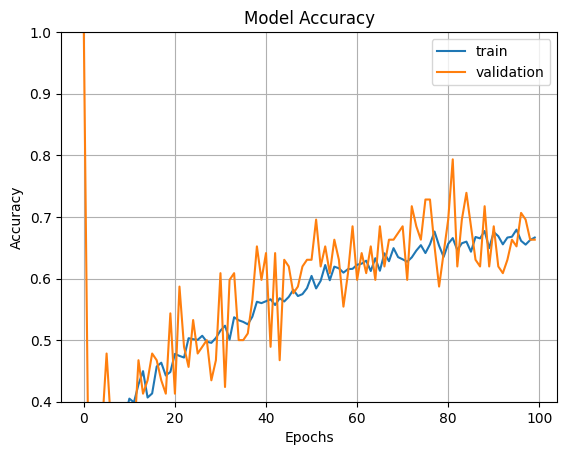

In [17]:
import matplotlib.pyplot as plt
fig1 = plt.gcf()
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("Ocak/Val_Accury_bacth64_epoch30.png",dpi=200)
plt.show()

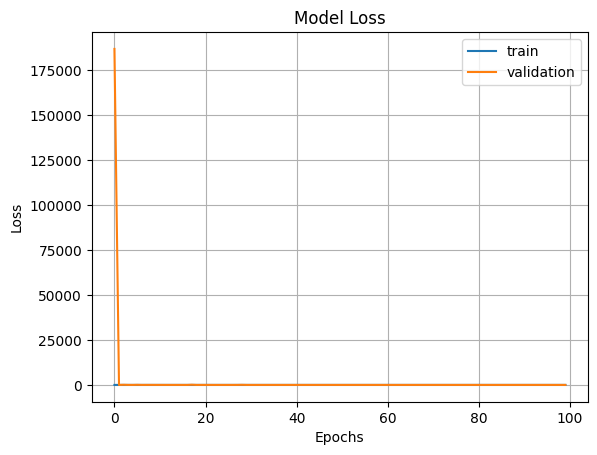

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig("Ocak/Val_Loss_bacth64_epoch30.png",dpi=200)
plt.show()

In [19]:
results = model.evaluate(val_generator, verbose=0)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

#_,acc=model.evaluate(val_generator)
#print(acc*100)    

Test Accuracy: 41.33%


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = np.argmax(model.predict(val_generator), axis=1)
matrix = confusion_matrix(val_generator.labels, predictions)
report= classification_report(val_generator.labels, predictions, target_names=val_generator.class_indices, zero_division=0)


2623/2623 [==============================] - 121s 46ms/step


In [21]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      balkon       0.00      0.00      0.00      1253
       banyo       0.00      0.00      0.00      1253
         bar       0.07      0.87      0.12      1283
         dış       0.00      0.00      0.00      1266
       havuz       0.00      0.00      0.00      1248
      mutfak       0.00      0.00      0.00      1278
         oda       0.06      0.04      0.05      1319
  resepsiyon       0.00      0.00      0.00      1221
    restoran       0.00      0.00      0.00      1265
       salon       0.00      0.00      0.00      1292
       sauna       0.00      0.00      0.00      1041
         spa       0.00      0.00      0.00      1209
        spor       0.00      0.00      0.00      1271
     veranda       0.00      0.00      0.00      1285

    accuracy                           0.07     17484
   macro avg       0.01      0.06      0.01     17484
weighted avg       0.01      0.07      0.01     17484

